<a href="https://colab.research.google.com/github/dp-repo/AIML-Training-Delshan/blob/main/practise_GradientDescent_05Oct2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import math
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

In [2]:
def f1(X):
    return torch.sum(torch.square(X))


def grad_f1(X):
    grad = torch.zeros_like(X)
    for i in range(len(X)):
        grad[i] = 2*X[i]
    return grad


In [3]:
x = torch.tensor([1,2,3]);
print('Original X: ', x)
print('f1(x): ',f1(x))
print('Calculated d(f1)/d(x): ',grad_f1(x))

Original X:  tensor([1, 2, 3])
f1(x):  tensor(14)
Calculated d(f1)/d(x):  tensor([2, 4, 6])


In [4]:
x = torch.tensor([4,5,6], dtype=float, requires_grad=True);
print('Original X: ', x)
y = f1(x)
print('f1(x): ', y)
dy = grad_f1(x)
print('Calculated gradient dy/dx: ', dy.data)
# calculate the gradients using autograd
y.backward()
# now dy/dx will be present in x.grad
print('Autograd dy/dx: ', x.grad)

Original X:  tensor([4., 5., 6.], dtype=torch.float64, requires_grad=True)
f1(x):  tensor(77., dtype=torch.float64, grad_fn=<SumBackward0>)
Calculated gradient dy/dx:  tensor([ 8., 10., 12.], dtype=torch.float64)
Autograd dy/dx:  tensor([ 8., 10., 12.], dtype=torch.float64)


In [5]:
# input
x = torch.tensor([2], dtype=float, requires_grad=True)
print('original x: ', x)
y = torch.tensor([5], dtype=float, requires_grad=True)
print('original y: ', y)

# calculate our function
def f2(x,y):
  w = x*x + y
  z = w**3
  return w, z

w,z = f2(x,y)
print('intermediate w: ', w.data)
print('z: ', z.data)

original x:  tensor([2.], dtype=torch.float64, requires_grad=True)
original y:  tensor([5.], dtype=torch.float64, requires_grad=True)
intermediate w:  tensor([9.], dtype=torch.float64)
z:  tensor([729.], dtype=torch.float64)


In [6]:
w.backward()
print('dw/dx : ', x.grad)
print('dw/dy : ', y.grad)

dw/dx :  tensor([4.], dtype=torch.float64)
dw/dy :  tensor([1.], dtype=torch.float64)


In [8]:
# we need to clear all previous gradients, otherwise, it will get added up
x = x.detach() #throw away the graph
y = y.detach()
x.requires_grad=True # to avoid the graph being discarded
y.requires_grad=True

w,z = f2(x,y)

z.backward()

print('dz/dx = dz/dw * dw/dx: ', x.grad)
print('dz/dy = dz/dw * dw/dy: ', y.grad)

dz/dx = dz/dw * dw/dx:  tensor([972.], dtype=torch.float64)
dz/dy = dz/dw * dw/dy:  tensor([243.], dtype=torch.float64)


In [9]:
#Let us try to find the minimum of a simple function x^2. First let us look at the graph of the function.

def f3(x):
  return x**2

def plot_function(function, start, end):
  x = torch.linspace(start, end, 1000)
  y = f3(x)
  plt.plot(x,y)


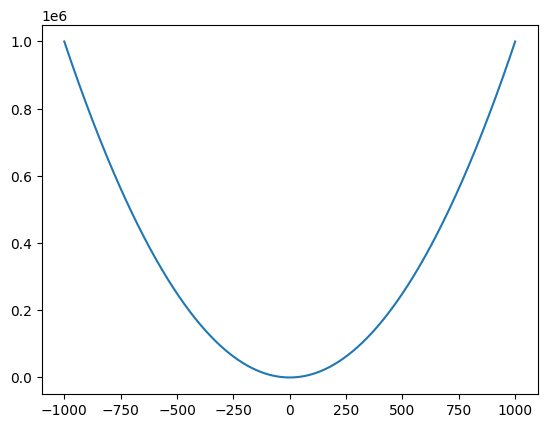

In [11]:
plot_function(f3, -1000,1000)
plt.show()

In [13]:
def gradient_descent_visualize(function, lr=0.1, convergence_threshold = 0.01, max_iter = 10000):
  x = torch.rand(1, requires_grad=True)
  x_history = []
  for ii in range(max_iter):
    y = function(x)
    y.backward()
    x_new = x - x.grad*lr
    if torch.abs(x_new - x) < convergence_threshold:
      x = x_new
      break
    # store the history of steps so that we can see
    x_history = x_history + [x_new]
    # zero the gradients
    x = x_new.detach()
    x.requires_grad = True

  return x, torch.tensor(x_history)

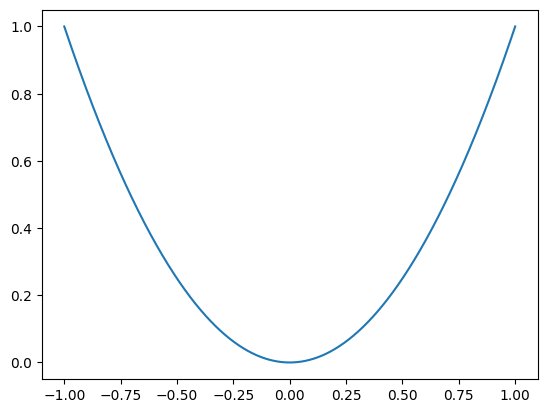

In [14]:
plot_function(f3, -1, 1)
plt.show()

In [15]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(32 * 5 * 5, 512)
        self.fc2 = nn.Linear(512, 128)
        # output layer 10 classes
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # flatten all dimensions except batch
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [16]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# Classes in CIFAR10
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:01<00:00, 95773889.27it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [17]:
print('Training data shape : ', trainset.data.shape, len(trainset.targets))
print('Testing data shape : ', testset.data.shape, len(testset.targets))

# Find the unique numbers from the train labels
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Training data shape :  (50000, 32, 32, 3) 50000
Testing data shape :  (10000, 32, 32, 3) 10000
Total number of outputs :  10
Output classes :  ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [18]:
def train(num_epochs, model, train_loader, loss_func, optimizer):

  # Training mode
  model.train()

  train_losses = []
  train_acc = []

  # Train the model
  for epoch in range(num_epochs):
    running_loss = 0
    running_acc = 0
    for i, (images, labels) in enumerate(train_loader):

      # clear gradients for this training step
      optimizer.zero_grad()  # Zero all your gradients

      # Forward pass
      output = model(images)

      # Calculate loss
      loss = loss_func(output, labels)

      # Backpropagation, compute gradients
      loss.backward()

      # Apply gradients
      optimizer.step()

      # Running loss
      running_loss += loss.item()

      # indices of max probabilities
      _, preds = torch.max(output, dim=1)

      # Calculate number of correct predictions
      correct = (preds.float() == labels).sum()
      running_acc += correct

      # Average loss and acc values
      epoch_loss = running_loss / len(train_loader.dataset)
      epoch_acc = running_acc / len(train_loader.dataset)

    train_losses.append(epoch_loss)
    train_acc.append(epoch_acc)
    print ('Epoch {}/{}, Loss: {:.4f}, Accuracy: {:.4f}'.format(epoch + 1, num_epochs, epoch_loss, epoch_acc*100))

  return train_losses, train_acc

In [20]:
def test_model(model, testloader):
  correct = 0
  total = 0
  # Deactivate autograd engine (don't compute grads since we're not training)
  with torch.no_grad():
    for data in testloader:
        images, labels = data
        # Calculate outputs by running images through the network
        outputs = model(images)
        # The class with the highest value is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

  print('Accuracy of the network: %d %%' % (
      100 * correct / total))

In [21]:
# start with a fresh model
model = Net()
print(model)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [23]:
# Cross Entropy loss for multi-class classification
criterion = nn.CrossEntropyLoss()

In [24]:
# SGD optimizer with momentum
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9)

In [25]:
num_epochs = 5  # iterations
train_losses, train_acc = train(num_epochs, model, trainloader, criterion, optimizer)

Epoch 1/5, Loss: 0.0131, Accuracy: 38.0480
Epoch 2/5, Loss: 0.0093, Accuracy: 57.5960
Epoch 3/5, Loss: 0.0077, Accuracy: 65.1940
Epoch 4/5, Loss: 0.0067, Accuracy: 70.0140
Epoch 5/5, Loss: 0.0057, Accuracy: 74.5720


In [26]:
# Accuracy on test data after training
test_model(model, testloader)

Accuracy of the network: 68 %
